# Marine heatwave prediction
### Code for NOAA AI workshop hackathon, September 2021
### Team JAM&G 

Jean Lim, Ayush Prasad, Mengyang Zhou, and George Cutter

jean.lim@noaa.gov, ayush.prd@gmail.com, mengyang.zhou@uconn.edu, george.cutter@noaa.gov

Github: https://github.com/MengyangZ/Marine_Heatwave_Prediction.git

In [1]:
import netCDF4 as nc
import xarray as xr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os


%matplotlib inline
from sklearn import svm, metrics, preprocessing
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

import xgboost as xgb
from xgboost import XGBClassifier

seed = 808
np.random.seed(seed)
random.seed(seed)

## Load testing data

In [2]:
t="oaflux_air_sea_fluxes_test.nc"
test = xr.open_dataset(t)
test

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, time: 60)
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 2016-01-01 2016-02-01 ... 2020-12-01
Data variables:
    evapr    (time, lat, lon) float32 ...
    lhtfl    (time, lat, lon) float32 ...
    nlwrs    (time, lat, lon) float32 ...
    hum2m    (time, lat, lon) float32 ...
    qnet     (time, lat, lon) float32 ...
    shtfl    (time, lat, lon) float32 ...
    nswrs    (time, lat, lon) float32 ...
    tmp2m    (time, lat, lon) float32 ...
    tmpsf    (time, lat, lon) float32 ...
    wnd10    (time, lat, lon) float32 ...

In [3]:
testdf = test.to_dataframe()

## Load training data
There are 412 monthly timepoints per latitude and longitude, and some lat/long have entirely NA values.

In [4]:
l="marine_heatwave_labels_train.nc"
labels = xr.open_dataset(l)
labels

<xarray.Dataset>
Dimensions:    (lon: 360, lat: 180, time: 412)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time       (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2015-12-01
Data variables:
    lsmask     (lat, lon) float32 ...
    mhw_label  (time, lat, lon) float32 ...

In [5]:
ldf=labels.to_dataframe()
ldf

lsmask  mhw_label
lon   lat   time                         
0.5   -89.5 1981-09-01     0.0        0.0
            1981-10-01     0.0        0.0
            1981-11-01     0.0        0.0
            1981-12-01     0.0        0.0
            1982-01-01     0.0        0.0
...                        ...        ...
359.5  89.5 2015-08-01     1.0        0.0
            2015-09-01     1.0        0.0
            2015-10-01     1.0        0.0
            2015-11-01     1.0        0.0
            2015-12-01     1.0        0.0

[26697600 rows x 2 columns]

In [6]:
d="oaflux_air_sea_fluxes_train.nc"
ds=xr.open_dataset(d)
ds

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, time: 412)
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2015-12-01
Data variables:
    evapr    (time, lat, lon) float32 ...
    lhtfl    (time, lat, lon) float32 ...
    nlwrs    (time, lat, lon) float32 ...
    hum2m    (time, lat, lon) float32 ...
    qnet     (time, lat, lon) float32 ...
    shtfl    (time, lat, lon) float32 ...
    nswrs    (time, lat, lon) float32 ...
    tmp2m    (time, lat, lon) float32 ...
    tmpsf    (time, lat, lon) float32 ...
    wnd10    (time, lat, lon) float32 ...

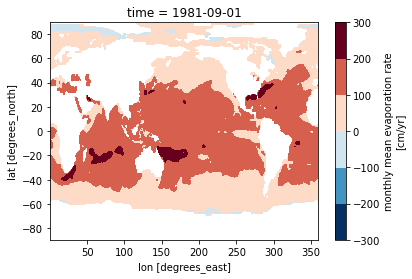

In [5]:
ds.isel(time=0).evapr.plot.contourf('lon','lat')

In [7]:
dataset=ds.to_dataframe()
dataset

evapr  lhtfl  nlwrs  hum2m  qnet  shtfl  nswrs  tmp2m  \
lon   lat   time                                                                
0.5   -89.5 1981-09-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            1981-10-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            1981-11-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            1981-12-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            1982-01-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
...                       ...    ...    ...    ...   ...    ...    ...    ...   
359.5  89.5 2015-08-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            2015-09-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            2015-10-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            2015-11-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            2015-12-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   

                        tmpsf  wnd10  
lon   lat   time                      
0.5   -89.5 1981-09-01    NaN    NaN  
            1981-10-01    NaN    NaN  
            1981-11-01    NaN    NaN  
            1981-12-01    NaN    NaN  
            1982-01-01    NaN    NaN  
...                       ...    ...  
359.5  89.5 2015-08-01    NaN    NaN  
            2015-09-01    NaN    NaN  
            2015-10-01    NaN    NaN  
            2015-11-01    NaN    NaN  
            2015-12-01    NaN    NaN  

[26697600 rows x 10 columns]

In [35]:
dataset.describe()

,evapr,lhtfl,nlwrs,hum2m,qnet,shtfl,nswrs,tmp2m,tmpsf,wnd10
count,1.511556e+07,1.511556e+07,1.162601e+07,1.511552e+07,1.162601e+07,1.511556e+07,1.162601e+07,1.511556e+07,1.515759e+07,1.511556e+07
mean,1.025593e+02,8.389664e+01,4.615635e+01,1.044722e+01,2.579577e+01,1.086995e+01,1.662040e+02,1.610614e+01,1.704797e+01,7.803652e+00
std,6.212181e+01,4.928893e+01,1.939643e+01,5.735984e+00,9.553876e+01,1.822858e+01,8.079781e+01,1.012560e+01,1.019781e+01,2.188787e+00
min,-9.140000e+01,-7.460000e+01,-5.940000e+01,2.800000e-01,-8.797000e+02,-1.489000e+02,0.000000e+00,-2.558000e+01,-1.500000e+00,4.000000e-02
25%,5.200000e+01,4.210000e+01,3.190000e+01,5.150000e+00,-3.850000e+01,2.800000e+00,1.042000e+02,6.840000e+00,7.250000e+00,6.110000e+00
50%,1.067000e+02,8.530000e+01,4.570000e+01,9.920000e+00,4.180000e+01,7.700000e+00,1.827000e+02,1.802000e+01,1.902000e+01,7.480000e+00
75%,1.497000e+02,1.191000e+02,6.000000e+01,1.650000e+01,9.770000e+01,1.400000e+01,2.317000e+02,2.572000e+01,2.639000e+01,9.160000e+00
max,7.027000e+02,5.616000e+02,1.762000e+02,2.599000e+01,3.099000e+02,5.930000e+02,3.469000e+02,3.751000e+01,3.534000e+01,3.033000e+01


In [6]:
# get the number of missing data points per column
missing_values_count = dataset.isnull().sum()

# how many total missing values do we have?
total_cells = np.product(dataset.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

47.28778466978305


## Create rolling seasonal average of monthly data
Create rolling half-yearly (time=6) average of monthly data

In [35]:
# Time = n months, minimum number of observations to have a value = 1
roll=ds.rolling(time=3,center=True,min_periods=1).mean()
rolldf=roll.to_dataframe()
# Combine prediction labels with rolling average data
rolldf['label']=ldf['mhw_label']
rolldf

evapr  lhtfl  nlwrs  hum2m  qnet  shtfl  nswrs  tmp2m  \
lon   lat   time                                                                
0.5   -89.5 1981-09-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            1981-10-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            1981-11-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            1981-12-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            1982-01-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
...                       ...    ...    ...    ...   ...    ...    ...    ...   
359.5  89.5 2015-08-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            2015-09-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            2015-10-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            2015-11-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
            2015-12-01    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   

                        tmpsf  wnd10  label  
lon   lat   time                             
0.5   -89.5 1981-09-01    NaN    NaN    0.0  
            1981-10-01    NaN    NaN    0.0  
            1981-11-01    NaN    NaN    0.0  
            1981-12-01    NaN    NaN    0.0  
            1982-01-01    NaN    NaN    0.0  
...                       ...    ...    ...  
359.5  89.5 2015-08-01    NaN    NaN    0.0  
            2015-09-01    NaN    NaN    0.0  
            2015-10-01    NaN    NaN    0.0  
            2015-11-01    NaN    NaN    0.0  
            2015-12-01    NaN    NaN    0.0  

[26697600 rows x 11 columns]

In [25]:
rolldf.dropna()

evapr      lhtfl      nlwrs     hum2m       qnet  \
lon   lat   time                                                           
0.5   -70.5 1984-01-01  26.10  21.299997  26.100000  3.010000  68.099998   
            1984-02-01  26.10  21.299997  26.100000  3.010000  68.099998   
            1985-01-01  12.50  10.199996  29.500000  2.960000  73.500000   
            1985-02-01  12.50  10.199996  29.500000  2.960000  73.500000   
            1986-01-01  22.90  18.699997  30.900000  2.540000  36.200001   
...                       ...        ...        ...       ...        ...   
359.5  89.5 1984-06-01   3.40   2.750000 -11.950000  3.290000   9.599999   
            1984-07-01  -2.75  -2.250000 -11.300000  3.640000  21.700001   
            1984-08-01  -5.05  -4.099999  -6.450000  3.760000  21.200001   
            1984-09-01  -3.50  -2.849999  -9.350000  3.640000  22.549999   
            1984-10-01  -2.20  -1.799999  -9.000001  3.560001  20.899998   

                            shtfl       nswrs  tmp2m  tmpsf      wnd10  label  
lon   lat   time                                                               
0.5   -70.5 1984-01-01 -15.300000  100.200005 -0.420 -1.320  11.230001    0.0  
            1984-02-01 -15.300000  100.200005 -0.420 -1.320  11.230001    0.0  
            1985-01-01  -7.800000  105.400002 -0.270 -1.270   4.820002    0.0  
            1985-02-01  -7.800000  105.400002 -0.270 -1.270   4.820002    0.0  
            1986-01-01   9.400001   95.400002 -2.540 -1.350   4.590002    0.0  
...                           ...         ...    ...    ...        ...    ...  
359.5  89.5 1984-06-01  -0.399999    0.000000 -0.990 -1.070   4.570000    0.0  
            1984-07-01  -8.049999    0.000000  0.290 -0.890   4.705000    0.0  
            1984-08-01 -10.549999    0.000000  0.615 -0.680   5.020000    1.0  
            1984-09-01  -9.699999    0.550000  0.180 -0.695   6.470000    1.0  
            1984-10-01  -8.899998    1.100000 -0.060 -0.810   7.110000    1.0  

[11833672 rows x 11 columns]

In [36]:
# Split x and y data with time lag
x_data = rolldf.iloc[:-3, 0:10]
y_data = ldf.iloc[3:, -1].astype('int16')
print(x_data.shape,y_data.shape)

(26697597, 10) (26697597,)


## Process data
Split data to input/output with time lag

In [10]:
#  Input (training data)
x_data = dataset.iloc[:-1, 0:10]

### Handle missing values

From [Kaggle](https://www.kaggle.com/alexisbcook/handling-missing-values):  

*   Replace missing values with whatever value comes directly after it in the same column
*   This makes a lot of sense for datasets where the observations have some sort of logical order to them

In [11]:
# Recode y=labels (float32) as integers
y_data = ldf.iloc[1:, -1].astype('int16')
y_data

lon    lat    time      
0.5    -89.5  1981-10-01    0
              1981-11-01    0
              1981-12-01    0
              1982-01-01    0
              1982-02-01    0
                           ..
359.5   89.5  2015-08-01    0
              2015-09-01    0
              2015-10-01    0
              2015-11-01    0
              2015-12-01    0
Name: mhw_label, Length: 26697599, dtype: int16

In [107]:
# replace all NA's with the value that comes directly after it in the same column, 
# then replace all the remaining na's with 0
# x_data.fillna(x_data.mean(),inplace=True)
x_data_bfill=x_data.fillna(method='bfill', axis=0).fillna(0)
x_data_bfill

evapr  lhtfl  nlwrs  hum2m       qnet  shtfl  \
lon   lat   time                                                           
0.5   -89.5 1981-09-01  23.200001   18.9   26.1   3.05  68.099998    0.5   
            1981-10-01  23.200001   18.9   26.1   3.05  68.099998    0.5   
            1981-11-01  23.200001   18.9   26.1   3.05  68.099998    0.5   
            1981-12-01  23.200001   18.9   26.1   3.05  68.099998    0.5   
            1982-01-01  23.200001   18.9   26.1   3.05  68.099998    0.5   
...                           ...    ...    ...    ...        ...    ...   
359.5  89.5 2015-07-01   0.000000    0.0    0.0   0.00   0.000000    0.0   
            2015-08-01   0.000000    0.0    0.0   0.00   0.000000    0.0   
            2015-09-01   0.000000    0.0    0.0   0.00   0.000000    0.0   
            2015-10-01   0.000000    0.0    0.0   0.00   0.000000    0.0   
            2015-11-01   0.000000    0.0    0.0   0.00   0.000000    0.0   

                             nswrs  tmp2m  tmpsf  wnd10  
lon   lat   time                                         
0.5   -89.5 1981-09-01  100.200005  -1.31  -1.33   9.24  
            1981-10-01  100.200005  -1.31  -1.33   9.24  
            1981-11-01  100.200005  -1.31  -1.33   9.24  
            1981-12-01  100.200005  -1.31  -1.33   9.24  
            1982-01-01  100.200005  -1.31  -1.33   9.24  
...                            ...    ...    ...    ...  
359.5  89.5 2015-07-01    0.000000   0.00   0.00   0.00  
            2015-08-01    0.000000   0.00   0.00   0.00  
            2015-09-01    0.000000   0.00   0.00   0.00  
            2015-10-01    0.000000   0.00   0.00   0.00  
            2015-11-01    0.000000   0.00   0.00   0.00  

[26697599 rows x 10 columns]

## Model building and testing


### XGBoost can handle missing data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=seed)
input_scaler=StandardScaler()
X_train_scaled=input_scaler.fit_transform(X_train)
X_test_scaled=input_scaler.transform(X_test)

In [38]:
params={'reg_lambda':2,'gamma':0.1,'learning_rate':0.01,'max_depth':10,'objective':'binary:logistic',
        'use_label_encoder':False}
xgbmod=XGBClassifier(**params)

xgbmod.fit(X_train_scaled, y_train,
        eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],early_stopping_rounds=10,verbose=True)

[16:42:22] WARNING: /opt/conda/conda-bld/xgboost-split_1620747856806/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68670	validation_1-logloss:0.68522
[1]	validation_0-logloss:0.67567	validation_1-logloss:0.67730
[2]	validation_0-logloss:0.67190	validation_1-logloss:0.66963
[3]	validation_0-logloss:0.66156	validation_1-logloss:0.66239
[4]	validation_0-logloss:0.65442	validation_1-logloss:0.65491
[5]	validation_0-logloss:0.64784	validation_1-logloss:0.64783
[6]	validation_0-logloss:0.64041	validation_1-logloss:0.64051
[7]	validation_0-logloss:0.63441	validation_1-logloss:0.63358
[8]	validation_0-logloss:0.62629	validation_1-logloss:0.62689
[9]	validation_0-logloss:0.62031	validation_1-logloss:0.62034
[10]	validation_0-logloss:0.61300	validation_1-logloss:0.61379
[11]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=64, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, subsample=1,
              tree_method='approx', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Randomized search to find best learning parameters to use for machine learning
> Randomized search is less exhaustive than grid search but still takes way too long (>10 hours) to run

In [ ]:
xgbobj=XGBClassifier(use_label_encoder=False)

# Define a set of parameters
params={'n_estimators':[100,500,1000],'reg_lambda':[2,1],'gamma':[0,0.3,0.2,0.1],'learning_rate':[0.01,0.03,0.05],
        'max_depth':[2,4,6,8,10],'objective':['binary:logistic']}

# Search for best parameters to use
xgb_search=RandomizedSearchCV(xgbobj,params,cv=10,n_jobs=-1,verbose=1)
xgb_search.fit(X_train_scaled, y_train,
        eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],early_stopping_rounds=10,verbose=True)

# Get best parameters 
xgb_mod.best_params_

> K-fold cross validation takes a long time to run and causes dead kernel

In [ ]:
data_dmatrix = xgb.DMatrix(x_data, label = y_data)

params={'reg_lambda':2,'gamma':0.1,'learning_rate':0.01,'max_depth':10,'objective':'binary:logistic'}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=50,early_stopping_rounds=10, as_pandas=True, seed=seed)

Train a XGBoost classifier model without grid/randomized search and cross-validation

### Support vector machine

Did not use because the predictions were all zeroes. Both training and testing sets are probably imbalanced.

In [175]:
# Make pipeline for SGDClassifier (stochastic gradient descent)

sgd_scaler=StandardScaler()

sgd = Pipeline([('scaler', sgd_scaler), 
                ('svc', SGDClassifier(n_jobs=-1,verbose=1,learning_rate='adaptive',eta0=0.01,
                                     early_stopping=True))])


In [ ]:
# Cross-validation; can be run reasonably quickly
sgd_scores = cross_val_score(sgd, x_data_bfill, y_data, cv=10)

-- Epoch 1
Norm: 0.17, NNZs: 10, Bias: -1.050000, T: 21625055, Avg. loss: 0.105204
Total training time: 3.98 seconds.
-- Epoch 2
Norm: 0.16, NNZs: 10, Bias: -1.100000, T: 43250110, Avg. loss: 0.105206
Total training time: 11.55 seconds.
-- Epoch 3
Norm: 0.15, NNZs: 10, Bias: -1.080000, T: 64875165, Avg. loss: 0.105205
Total training time: 19.11 seconds.
-- Epoch 4
Norm: 0.17, NNZs: 10, Bias: -1.070000, T: 86500220, Avg. loss: 0.105204
Total training time: 26.68 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 10, Bias: -1.100000, T: 108125275, Avg. loss: 0.105202
Total training time: 34.25 seconds.
-- Epoch 6
Norm: 0.17, NNZs: 10, Bias: -1.110000, T: 129750330, Avg. loss: 0.105204
Total training time: 41.82 seconds.
-- Epoch 7
Norm: 0.05, NNZs: 10, Bias: -1.016000, T: 151375385, Avg. loss: 0.100291
Total training time: 49.37 seconds.
-- Epoch 8
Norm: 0.05, NNZs: 10, Bias: -1.016000, T: 173000440, Avg. loss: 0.100290
Total training time: 56.94 seconds.
-- Epoch 9
Norm: 0.04, NNZs: 10, Bias: -1.024

-- Epoch 33
Norm: 0.00, NNZs: 10, Bias: -1.000005, T: 713626815, Avg. loss: 0.099062
Total training time: 247.59 seconds.
-- Epoch 34
Norm: 0.00, NNZs: 10, Bias: -1.000006, T: 735251870, Avg. loss: 0.099062
Total training time: 255.20 seconds.
-- Epoch 35
Norm: 0.00, NNZs: 10, Bias: -1.000005, T: 756876925, Avg. loss: 0.099062
Total training time: 262.82 seconds.
-- Epoch 36
Norm: 0.00, NNZs: 10, Bias: -1.000004, T: 778501980, Avg. loss: 0.099062
Total training time: 270.43 seconds.
Convergence after 36 epochs took 274.02 seconds
-- Epoch 1
Norm: 0.17, NNZs: 10, Bias: -1.100000, T: 21625055, Avg. loss: 0.105140
Total training time: 3.98 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 10, Bias: -1.080000, T: 43250110, Avg. loss: 0.105140
Total training time: 11.56 seconds.
-- Epoch 3
Norm: 0.20, NNZs: 10, Bias: -1.090000, T: 64875165, Avg. loss: 0.105137
Total training time: 19.13 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 10, Bias: -1.100000, T: 86500220, Avg. loss: 0.105138
Total training time: 26.7

-- Epoch 28
Norm: 0.00, NNZs: 10, Bias: -1.000032, T: 605501540, Avg. loss: 0.099064
Total training time: 209.86 seconds.
-- Epoch 29
Norm: 0.00, NNZs: 10, Bias: -1.000019, T: 627126595, Avg. loss: 0.099064
Total training time: 217.48 seconds.
-- Epoch 30
Norm: 0.00, NNZs: 10, Bias: -1.000035, T: 648751650, Avg. loss: 0.099064
Total training time: 225.11 seconds.
-- Epoch 31
Norm: 0.00, NNZs: 10, Bias: -1.000026, T: 670376705, Avg. loss: 0.099064
Total training time: 232.74 seconds.
-- Epoch 32
Norm: 0.00, NNZs: 10, Bias: -1.000006, T: 692001760, Avg. loss: 0.099062
Total training time: 240.38 seconds.
-- Epoch 33
Norm: 0.00, NNZs: 10, Bias: -1.000007, T: 713626815, Avg. loss: 0.099062
Total training time: 248.00 seconds.
-- Epoch 34
Norm: 0.00, NNZs: 10, Bias: -1.000008, T: 735251870, Avg. loss: 0.099062
Total training time: 255.63 seconds.
-- Epoch 35
Norm: 0.00, NNZs: 10, Bias: -1.000005, T: 756876925, Avg. loss: 0.099062
Total training time: 263.26 seconds.
-- Epoch 36
Norm: 0.00, 

### Neural network

Predictions were also all zeroes

In [168]:
for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(x_data_bfill, y_data, test_size=0.1, random_state=808)
 
  # Scale each feature to a given range. Make sure to not re-fit the scaler on the validation/test data and only transform() it.
  input_scaler = StandardScaler()
  scaled_X_train = input_scaler.fit_transform(X_train)
  scaled_X_test = input_scaler.transform(X_test)

  # Create dense neural network model
  model = Sequential()
  # 4 neurons, 10 input columns
  model.add(Dense(4, input_dim=10, activation='relu'))
  model.add(Dense(4, activation='relu'))
  # 1 neuron
  model.add(Dense(1, activation='sigmoid'))

  model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'])
  
  early_stopping = keras.callbacks.EarlyStopping(
      patience=10,
      min_delta=0.001,
      restore_best_weights=True)

  history = model.fit(
        scaled_X_train, y_train,
        validation_data=(scaled_X_test, y_test),
        batch_size=10000,
        epochs=1000,
        callbacks=[early_stopping],
        verbose=1)

Epoch 1/1000
2403/2403 [==============================] - 9s 3ms/step - loss: nan - binary_accuracy: 0.9450 - val_loss: nan - val_binary_accuracy: 0.9449
Epoch 2/1000
2403/2403 [==============================] - 7s 3ms/step - loss: nan - binary_accuracy: 0.9450 - val_loss: nan - val_binary_accuracy: 0.9449
Epoch 3/1000
2403/2403 [==============================] - 7s 3ms/step - loss: nan - binary_accuracy: 0.9450 - val_loss: nan - val_binary_accuracy: 0.9449
Epoch 4/1000
2403/2403 [==============================] - 7s 3ms/step - loss: nan - binary_accuracy: 0.9450 - val_loss: nan - val_binary_accuracy: 0.9449
Epoch 5/1000
2403/2403 [==============================] - 7s 3ms/step - loss: nan - binary_accuracy: 0.9450 - val_loss: nan - val_binary_accuracy: 0.9449
Epoch 6/1000
2403/2403 [==============================] - 7s 3ms/step - loss: nan - binary_accuracy: 0.9450 - val_loss: nan - val_binary_accuracy: 0.9449
Epoch 7/1000
2403/2403 [==============================] - 7s 3ms/step - loss

Best Validation Loss: nan
Best Validation Accuracy: 0.9449


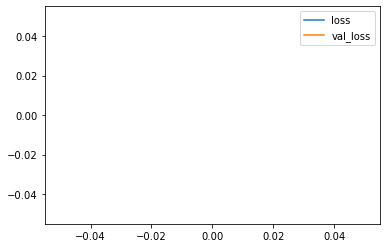

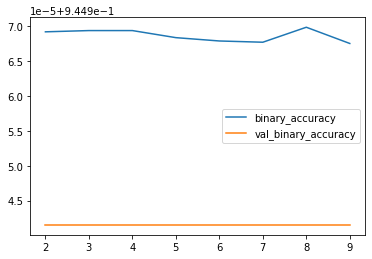

In [169]:
# Plot loss and binary accuracy
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 2
history_df.loc[2:, ['loss', 'val_loss']].plot()
history_df.loc[2:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

## Make predictions with model

Only XG boost models were used for predictions because they produce both positive and negative predictions

Transform test data with scaler before making predictions

In [39]:
# Only used for XGboost transformer
test_scaled=input_scaler.transform(testdf)
test_scaled

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [144]:
# Used for models that do not take NA values
test_filled=testdf.fillna(method='bfill', axis=0).fillna(0)
test_filled

evapr      lhtfl  nlwrs     hum2m  qnet  \
lon   lat   time                                                      
0.5   -89.5 2016-01-01  67.111267  73.742226    0.0  2.576281   0.0   
            2016-02-01  67.111267  73.742226    0.0  2.576281   0.0   
            2016-03-01  67.111267  73.742226    0.0  2.576281   0.0   
            2016-04-01  67.111267  73.742226    0.0  2.576281   0.0   
            2016-05-01  67.111267  73.742226    0.0  2.576281   0.0   
...                           ...        ...    ...       ...   ...   
359.5  89.5 2020-08-01  -7.081978  -5.783386    0.0  3.563950   0.0   
            2020-09-01   0.000000   0.000000    0.0  0.000000   0.0   
            2020-10-01   0.000000   0.000000    0.0  0.000000   0.0   
            2020-11-01   0.000000   0.000000    0.0  0.000000   0.0   
            2020-12-01   0.000000   0.000000    0.0  0.000000   0.0   

                            shtfl  nswrs     tmp2m     tmpsf      wnd10  
lon   lat   time                                                         
0.5   -89.5 2016-01-01  23.325121    0.0 -2.189504 -1.460590  19.276512  
            2016-02-01  23.325121    0.0 -2.189504 -1.460590  19.276512  
            2016-03-01  23.325121    0.0 -2.189504 -1.460590  19.276512  
            2016-04-01  23.325121    0.0 -2.189504 -1.460590  19.276512  
            2016-05-01  23.325121    0.0 -2.189504 -1.460590  19.276512  
...                           ...    ...       ...       ...        ...  
359.5  89.5 2020-08-01 -15.604411    0.0  0.107507 -1.464998   6.090893  
            2020-09-01   0.000000    0.0  0.000000  0.000000   0.000000  
            2020-10-01   0.000000    0.0  0.000000  0.000000   0.000000  
            2020-11-01   0.000000    0.0  0.000000  0.000000   0.000000  
            2020-12-01   0.000000    0.0  0.000000  0.000000   0.000000  

[3888000 rows x 10 columns]

In [40]:
# Make predictions with model
pred=xgbmod.predict(test_scaled)
# Check prediction labels
np.unique(pred)

array([0])

In [41]:
# Append predictions to test data and reset index of dataframe
xg_df = testdf.copy().reset_index()
xg_df['mhw_label']=pred
xg_df

,lon,lat,time,evapr,lhtfl,nlwrs,hum2m,qnet,shtfl,nswrs,tmp2m,tmpsf,wnd10,mhw_label
0,0.5,-89.5,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.5,-89.5,2016-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.5,-89.5,2016-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.5,-89.5,2016-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.5,-89.5,2016-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3887995,359.5,89.5,2020-08-01,-7.081978,-5.783386,NaN,3.56395,NaN,-15.604411,NaN,0.107507,-1.464998,6.090893,0
3887996,359.5,89.5,2020-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3887997,359.5,89.5,2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3887998,359.5,89.5,2020-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [43]:
# Check how many positive predictions were made
xg_df[xg_df["mhw_label"] > 0]

,lon,lat,time,evapr,lhtfl,nlwrs,hum2m,qnet,shtfl,nswrs,tmp2m,tmpsf,wnd10,mhw_label


### Convert predictions to netCDF format

> Please make sure you meet the submission format checklist:
> - netCDF4 format (similar to the label data used in training);
> - File contains “lat”, “lon”, “time” as the dimension of the netCDF4 file;
> - “lat”, “lon”, and “time” should be identical with the one from “oaflux_air_sea_fluxes_test.nc”;
> - File should contain a variable named “mhw_labels”;
> - The dimension of “mhw_labels” should be [time, lon, lat];
> - File name of the submission should be “marine_heatwave_predict.nc”


In [33]:
xg_ds = xg_df.set_index(['time','lon', 'lat']).to_xarray()
xg_ds=xg_ds.drop_vars(['evapr','lhtfl','nlwrs','hum2m','qnet','shtfl','nswrs','tmp2m','tmpsf','wnd10'])
xg_ds.to_netcdf("marine_heatwave_predict.nc")

In [34]:
xg_ds

<xarray.Dataset>
Dimensions:    (time: 60, lon: 360, lat: 180)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01 2016-02-01 ... 2020-12-01
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    mhw_label  (time, lon, lat) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0